# NA540 Homework 8 - Estimation of Maneuvering Dynamics

MEMORANDUM

**DATE:** 12/04/2019

**TO:** A.W.Troesch, NA 540 Instructor

**FROM:** Wenzhe Xu, NA 540 Student

**RE:** NA540 Homework 8, Estimation of maneuvering dynamics.


## Executive Summary

This homework is to 

## Problem 1


In [1]:
import math

def VO6(x, ui): 
    """
    returns the time derivates of the state vector
    
    INPUTS: 
    x = [u v r psi xpos ypos delta]
    u      = perturbed surge velocity [m/s]
    v      = perturbed sway velocity [m/s]
    r      = perturbed yaw velocity [rad/s]
    psi    = perturbed yaw angle [rad]
    xpos   = position in x-direction [m]
    ypos   = position in y-direction [m]
    delta  = actual rudder angle [rad]
    
    ui = delta_c, commanded rudder angle [rad]
    Reference: M.S. Chislett and J. Stroem-Tejsen (1965)
               Planar Motion Mechanism Tests and Full-Scale Steering
               and Maneuvering Predictions for a Mariner Class Vessel,
               Technical Report Hy-5
               Hydro- and Aerodynamics Laboratory, Lyngby, Denmark.
    """
    if len(x) != 7:
        return []
    
    # Nominal Velocity [m/s]
    U0 = 7.7175 # m/s, about 15 knots
    V0 = 0.0
    
    # Normalization variables
    L = 160.93
    U = math.sqrt((U0 + x[0])**2 + x[1]**2)
    
    # Non-dimensional states and inputs
    delta_c = ui;
    
    u     = x[0]/U
    v     = x[1]/U
    r     = x[2]*L/U
    psi   = x[3]
    delta = x[6]
    
    # Parameters, hydrodynamic derivatives and main dimensions
    delta_max = 10 # max rudder angle [deg]
    Ddelta_max = 5 # max rudder derivative [deg/s]
    
    m  = 798e-5
    Iz = 39.2e-5
    xG = -0.023
    
    Xudot =  -42e-5;   Yvdot =  -748e-5;   Nvdot = 4.646e-5;
    Xu    = -184e-5;   Yrdot =-9.354e-5;   Nrdot = -4.38e-5;
    Xuu   = -110e-5;   Yv    = -1160e-5;   Nv    =  -264e-5;
    Xuuu  = -215e-5;   Yr    =  -499e-5;   Nr    =  -166e-5;
    Xvv   = -899e-5;   Yvvv  = -8078e-5;   Nvvv  =  1636e-5;
    Xrr   =   18e-5;   Yvvr  = 15356e-5;   Nvvr  = -5483e-5;
    Xdd   =  -95e-5;   Yvu   = -1160e-5;   Nvu   =  -264e-5;
    Xudd  = -190e-5;   Yru   =  -499e-5;   Nru   =  -166e-5;
    Xrv   =  798e-5;   Yd    =   278e-5;   Nd    =  -139e-5;
    Xvd   =   93e-5;   Yddd  =   -90e-5;   Nddd  =    45e-5;
    Xuvd  =   93e-5;   Yud   =   556e-5;   Nud   =  -278e-5;                   
                       
    Yuud  =   278e-5;   Nuud  =  -139e-5;                   
    Yvdd  =    -4e-5;   Nvdd  =    13e-5;                   
    Yvvd  =  1190e-5;   Nvvd  =  -489e-5;                   
    Y0    =    -4e-5;   N0    =     3e-5;                   
    Y0u   =    -8e-5;   N0u   =     6e-5;                   
    Y0uu  =    -4e-5;   N0uu  =     3e-5;
    
#     # assert control-fixed stability, C > 0
#     C = Yv * Nr - Nv * Yr
#     assert C > 0
    
    # Masses and moments of inertia
    m11 = m-Xudot
    m22 = m-Yvdot
    m23 = m*xG-Yrdot
    m32 = m*xG-Nvdot
    m33 = Iz-Nrdot
    
    # Rudder saturation and dynamics
    if abs(delta_c) >= delta_max*math.pi/180:
        delta_c = delta_max*math.pi/180 if delta_c > 0 else -delta_max*np.pi/180
    delta_dot = delta_c - delta
    if abs(delta_dot) >= Ddelta_max*math.pi/180:
        delta_dot = Ddelta_max*math.pi/180 if delta_dot > 0 else -Ddelta_max*np.pi/180
        
    # Forces and moments
    X = Xu*u + Xuu*u**2 + Xuuu*u**3 + Xvv*v**2 + Xrr*r**2 + Xrv*r*v + Xdd*delta**2 + \
        Xudd*u*delta**2 + Xvd*v*delta + Xuvd*u*v*delta
    Y = Yv*v + Yr*r + Yvvv*v**3 + Yvvr*v**2*r + Yvu*v*u + Yru*r*u + Yd*delta + \
        Yddd*delta**3 + Yud*u*delta + Yuud*u**2*delta + Yvdd*v*delta**2 + \
        Yvvd*v**2*delta + (Y0 + Y0u*u + Y0uu*u**2)
    N = Nv*v + Nr*r + Nvvv*v**3 + Nvvr*v**2*r + Nvu*v*u + Nru*r*u + Nd*delta + \
        Nddd*delta**3 + Nud*u*delta + Nuud*u**2*delta + Nvdd*v*delta**2 + \
        Nvvd*v**2*delta + (N0 + N0u*u + N0uu*u**2)
    
    # Dimensional state derivative
    xdot = [X*(U**2/L)/m11,
            -(-m33*Y+m23*N)*(U**2/L)/(m22*m33-m23*m32),
            (-m32*Y+m22*N)*(U**2/L**2)/(m22*m33-m23*m32),
            r*(U/L),
            (math.cos(psi)*(U0/U+u) - math.sin(psi)*v)*U,
            (math.sin(psi)*(U0/U+u) + math.cos(psi)*v)*U,
            delta_dot]
    
    return xdot

In [7]:
import numpy as np

def sim_Euler_Explicit(x0, u, time):
    assert len(u) == len(time)
    dt = time[1] - time[0]
    res = np.zeros((len(time), 7)) # state vector dimension = 7
    res[0,:] = x0
    for i in range(1, len(time)):
        res[i,:] = res[i-1,:] + dt * np.array(VO6(res[i-1,:], u[i-1]))
    return res


time = np.arange(0, 500, 0.5)
# u_const = np.ones(time.shape) * 2*np.pi/180
u_const = np.zeros(time.shape)
simulations = sim_Euler_Explicit([0.0]*7, u_const, time)

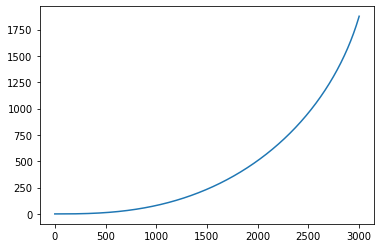

In [8]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(simulations[:,4], simulations[:,5])
plt.show()

In [6]:
VO6(np.ones(7), 1)

[4.319193922113506,
 -2.30775575395289,
 -0.3389203458924941,
 0.9999999999999999,
 3.8686143665976123,
 7.875825615930979,
 -0.08726646259971647]